<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Kernel Principal Component Analysis**


Rumor has it that the ultra-wealthy community consists of either investment bankers or entrepreneurs in the tech industry that dropped out of college. Is that stereotype really true? Ever wonder if the top billionaires in the world share anything in common? Although, we can't say with certainty what it takes to be one, we do have a way to determine if any patterns exist among the richest people in the world.

In this notebook, you will explore Kernel Principal Component Analysis (Kernel PCA) - an extension of principal component analysis (PCA) - to extract key feature patterns in the dataset, which is usually of higher dimension. In addition to analyzing billionaires around the globe, we will also use this unsupervised learning technique to denoise images.

![img](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/images/RichPeople.png)


## **Table of Contents**

<!-- <a href="#Principle-Component-Analysis">Principle Component Analysis</a> -->

<ol>
    <li><a href="https://#Objectives">Objectives</a>
        <ol>
            <li><a href="https://#Datasets">Datasets</a></li>
        </ol>
    </li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="https://#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="https://#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="https://#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>
    </li>
    <li>
        <a href="https://#Background">Background</a>
        <ol>
            <li><a href="https://#What-does-kernel-PCA-do-?">What does PCA do?</a></li>
        </ol>
    </li>
    <li>
        <a href="https://#Visual-Example-Transform-a-Dataset-Before-Applying-PCA">Visual Example - Transform a Dataset Before Applying PCA  </a>
        <ol>
            <li><a href="https://#Apply-PCA"> Apply PCA </a></li>
            <li><a href="https://#Transform-a-Dataset-to-a-Higher-Dimension-and-Then-Apply-PCA">Transform a Dataset to a Higher Dimension and Then Apply PCA</a></li>
        </ol>
    </li>
     <li>
        <a href="https://#Kernel-PCA"> Kernel PCA </a>
        <ol>
            <li><a href="https://#Whats-a-Kernel">What's a Kernel? </a></li>
            <li><a href="https://https://#Applying-Kernel-PCA">Applying Kernel PCA</a></li>
        </ol>
    </li>
    <li>
        <a href="https://#Using-Kernel-PCA-to-Predict-if-Youre-the-Richest-Person-in-the-World"> Using  Kernel PCA to Predict if You're the Richest Person in the World </a>
        <ol>
            <li><a href="https://#Data-Analysis">Data Analysis</a></li>
            <li><a href="#Applying-Kernel-PCA">Applying Kernel PCA</a></li>
            <li><a href="https://#Using-Kernel-PCA-to-Improve-Visualization">Using Kernel PCA to Improve Visualization  </a></li>
            <li><a href="https://#Using-Kernel-PCA-to-Improve-Prediction">Using Kernel PCA to Improve Prediction </a></li>
        </ol>
    </li>
</ol>

<a href="https://#Exercises">Exercises</a>

<ol>
    <li><a href="https://#Exercise-1---Fitting-PCA-Kernel">Exercise 1 - Fitting PCA and Kernel PCA Objects</a></li>
    <li><a href="https://#Exercise-2---Reconstruct-the-Digits">Exercise 2 - Reconstruct the Digits</a></li>
    <li><a href="https://#Exercise-3---Visualize-Denoised-Digit-Images">Exercise 3 - Visualize Denoised Digit Images</a></li>
</ol>


## Objectives

After completing this lab, you will be able to:

*   **Understand** why we  transform a dataset to a higher dimension and apply PCA.
*   **Understand** what is Kernel PCA.
*   **Apply** Kernel PCA effectively to real world datasets for purposes ranging from prediction to visualization.


### Installing Required Libraries

The following required modules are pre-installed in the Skills Network Labs environment. However if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Anaconda) you will need to install these libraries by removing the `#` sign before `!mamba` in the following code cell.


In [2]:
import numpy as np
import pandas as pd
from itertools import accumulate

import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge

In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
sns.set_context('notebook')
sns.set_style('white')

### Installing Required Libraries

The following required modules are pre-installed in the Skills Network Labs environment. However if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Anaconda) you will need to install these libraries by removing the `#` sign before `!mamba` in the following code cell.


In [6]:
def plot_proj(A,v,y,name=None):

    plt.scatter(A[:, 0] ,A[:, 1], label='data', c=y, cmap='viridis')
    
    #plt.plot(np.linspace(A[:,0].min(),A[:,0].max()),np.linspace(A[:,1].min(),A[:,1].max())*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5,label=name)   
    plt.plot(np.linspace(-1, 1), np.linspace(-1, 1) * (v[1] / v[0]), color='black', linestyle='--', linewidth=1.5, label=name)  
    # Run through all the data

    for i in range(len(A[:, 0]) - 1):
        #data point 
        w=A[i, :]

        # projection
        cv = (np.dot(A[i, :], v)) / np.dot(v, np.transpose(v)) * v

        # line between data point and projection
        plt.plot([A[i, 0], cv[0]], [A[i, 1], cv[1]],'r--', linewidth=1.5)

    plt.plot([A[-1, 0], cv[0]], [A[-1, 1], cv[1]], 'r--', linewidth=1.5, label='projections' )
    plt.legend()
    plt.show()

## Background

Kernel principal component analysis (kernel PCA) is an extension of principal component analysis (PCA) using kernel methods to map the data to a higher dimensional space, then performs PCA.


### What does kernel PCA do?

Kernel PCA maps the data into a higher dimensional space then performs PCA. The mapping to the higher dimensional space may be difficult to calculate, so the mapping is done via a kernel. As a result, you don't need to calculate the mapping, but you get all the benefits. The process is shown here:

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/images/image.png"  />
</center>

Many standard tasks can be done with PCA, but in many applications, you may get a better result using kernel PCA. Applications include:

*   Reduce the dimensionality of data
    *   By reducing data dimensionality, PCA can also help with visualization
*   May reduce noise in the process
*   Can be used to pre-process data improving the result of your algorithm


# Visual Example: Transform a Dataset Before Applying  PCA

Let's look at an example that will visually demonstrate kernel PCA in action. Consider the `make_circles` toy dataset. The dataset contains a large ring of one class, enclosing a smaller ring of another class in 2 dimensions.


In [7]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1000, factor=0.01, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

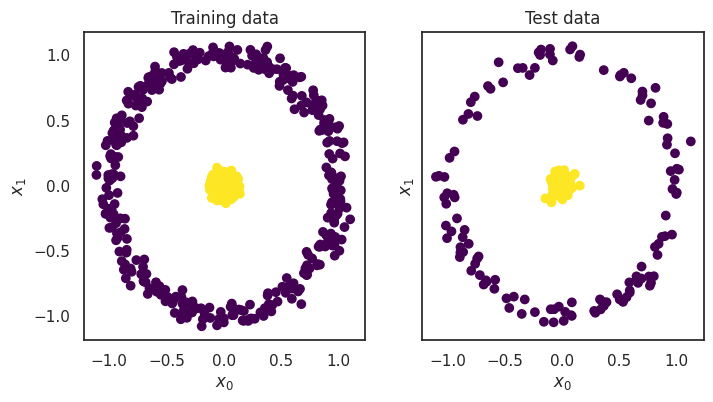

In [8]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
train_ax.set_xlabel(f"$x_{0}$")
train_ax.set_ylabel(f"$x_{1}$")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis')
test_ax.set_xlabel(f"$x_{0}$")
test_ax.set_ylabel(f"$x_{1}$")
test_ax.set_title("Test data")
plt.show()

### Apply PCA


There are several issues with the dataset above, the first being samples from each class cannot be linearly separated: no plane can split the samples of the inner ring from the outer ring. Let's see what happens when we perform PCA and evaluate the projection or score.


In [10]:
pca = PCA(n_components=2)
pca.fit(X_train)
score_pca = pca.transform(X_test)
pca

PCA(n_components=2)

We can plot the 2 principal components:


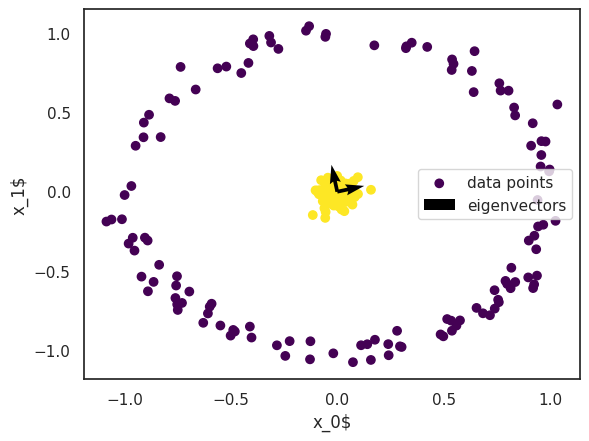

In [11]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test, label="data points", cmap="viridis")
plt.quiver([0, 0], [0, 0], pca.components_[0, :], pca.components_[1, :], label="eigenvectors")
plt.xlabel(f"x_{0}$")
plt.ylabel(f"x_{1}$")
plt.legend(loc="center right")
plt.show()

The following red lines show the direction of projection onto the first principal component (the black dotted line) for each data point.


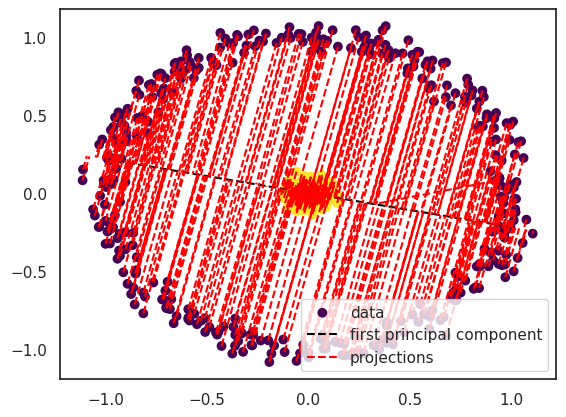

In [12]:
plot_proj(X_train, pca.components_[0, :], y_train, "first principal component")

We can also plot out the actual points of projection onto the first principal component, which are also known as their scores for the PC. We see that the dataset is not linearly separable, as data points from different classes cannot be separated with a plane:


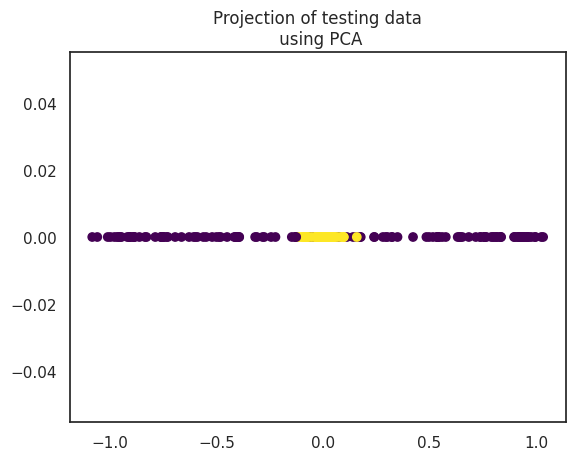

In [13]:
plt.scatter(score_pca[:, 0], np.zeros(score_pca[:, 0].shape[0]), c=y_test, cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.show()

If we plot the projection onto both principal components, we see the data looks the same, or isotropic, meaning that it has the same value when measured in a different coordinate system. This is because the data is symmetric and the variance is equal on each side. As a result, PCA will not help us classify the data.


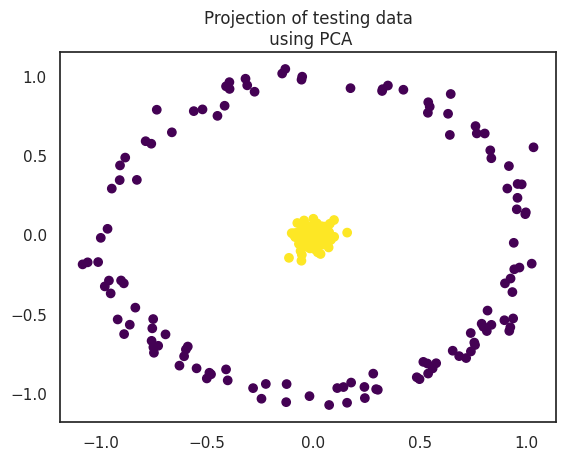

In [14]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test, cmap="viridis")
plt.title("Projection of testing data\n using PCA")
plt.show()

Building a Logistic Regression model on the training set, we can see that the accuracy score is around 50%, suggesting that the model is arbitrarily worse. Hence, we can see that it'd be unsuitable to project the data onto a low-dimensional linear subspace.


In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [17]:
print(f"Test set mean accuracy score for PCA: {lr.score(X_test, y_test)}")

Test set mean accuracy score for PCA: 0.496


### Transform a Dataset to a Higher Dimension and then Apply PCA


Instead, let's first apply the following polynomial transformation to the data:


In [18]:
PHI_train = np.concatenate((X_train, (X_train ** 2).sum(axis=1).reshape(-1, 1)), axis=1)
PHI_test = np.concatenate((X_test, (X_test ** 2).sum(axis=1).reshape(-1, 1)), axis=1)

We can plot the result  where  on the horizontal axis we have $x\_1$ and $x\_2$, and on the vertical axis we have $x\_1^2+x\_2^2$. We see that the larger ring has been mapped upwards in the vertical direction as the sum of its squared components is larger.


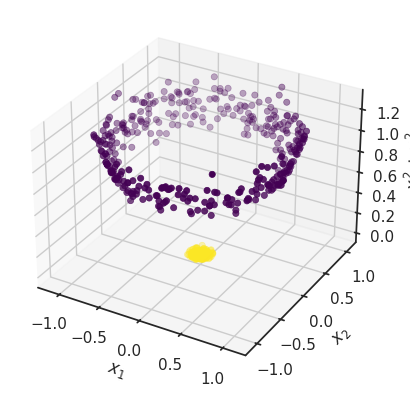

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(PHI_train[:, 0], PHI_train[:, 1], PHI_train[:, 2], c=y_train, cmap='viridis', linewidth=0.5)
ax.set_xlabel(f"$x_{1}$")
ax.set_ylabel(f"$x_{2}$")
ax.set_zlabel(f"$x_{1}^2+x_{2}^2$")
plt.show()

We then perform PCA on this transformed data, specifying we want to keep the top three principal components.


In [21]:
pca = PCA(n_components=3)
pca.fit(PHI_train)
score_polly = pca.transform(PHI_test)

Again, like we have previously done, we can plot out the data points' projection onto the first PC/scores. Below, we see that the dataset is almost linearly separable.


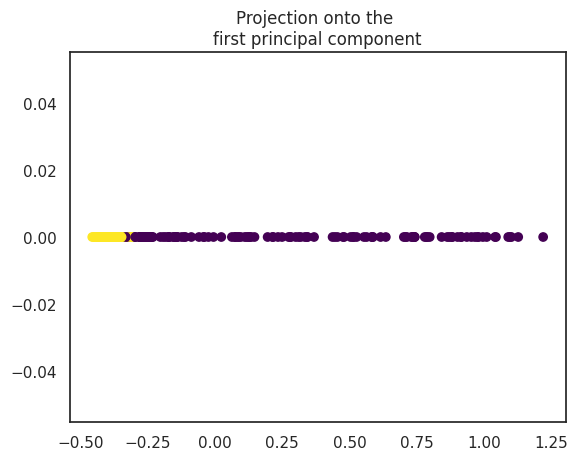

In [22]:
plt.scatter(score_polly[:, 0], np.zeros(score_polly[:, 1].shape[0]), c=y_test, cmap='viridis')
plt.title("Projection onto the \nfirst principal component")
plt.show()

Projecting onto a plane formed by the top two principal components (the ones with the largest absolute eigenvalues), we see the dataset is linearly separable with the exception of a couple of points.


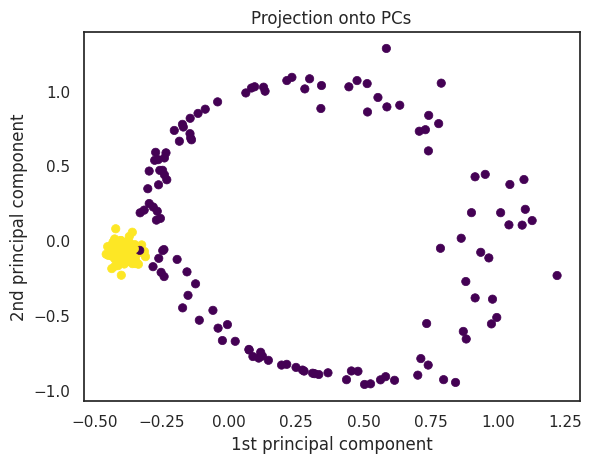

In [24]:
plt.scatter(score_polly[:, 0], score_polly[:, 1],c=y_test, cmap='viridis', linewidth=0.5)
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection onto PCs")
plt.show()

By building a Logistic Regression model on the training set, we see the accuracy is much better


In [26]:
lr = LogisticRegression()
lr.fit(PHI_train, y_train)
print(f"Test set mean accuracy score for Kernel PCA: {lr.score(PHI_test, y_test)}")

Test set mean accuracy score for Kernel PCA: 1.0


The actual polynomial transform for 2 dimensions is given by:


$\phi(\mathbf{x}) = \[x\_2^2, x\_1^2,  \sqrt{2} x\_{2} x\_{1}, \sqrt{2c} x\_1, \sqrt{2c} x\_2, c ]$


For $D$ dimensions, this  generalizes to:


Calculating the transform is of order $\mathcal{O}(D^2)$, therefore if $D=2$ the complexity is 4, for $D=5$ the complexity is 25, and so on. In addition to the cost of calculating $\phi(\mathbf{x})$, you also have the cost of calculating the empirical covariance matrix. Although, the demonstrated example is for a second-order polynomial, the sample applies for higher order polynomials.


## Kernel PCA


### What's a Kernel?


From the previous example, we can see that mapping the data to a higher dimension first is helpful. It turns out, we can use the kernel trick to perform PCA in this transformed space without calculating polynomial transformation explicitly. For two samples $\mathbf{x}$ and  $ \mathbf{x'} $, we can calculate the second order polynomial kernel by setting $p=2$ and applying the following:


$k(\mathbf{x}, \mathbf{x'}) = \phi(\mathbf{x})^\mathsf{T}\phi(\mathbf{x'}) = (\mathbf{x}^\mathsf{T} \mathbf{x'} + c)^{p} $, where $c$ is a constant usually one


This is of complexity $\mathcal{O}(D)$ coming from $\mathbf{x}^\mathsf{T} \mathbf{x}$; we can also increase the order of the polynomial by changing $p$ and that wouldn't change the computation complexity.


In this lab we used the <a href=https://en.wikipedia.org/wiki/Radial_basis_function_kernel?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01>Radial Basis Function (RBF) kernel </a> - the  dimension $\phi(\mathbf{x})$ is infinite, but the kernel is simple to calculate as shown here:


$k(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {|\mathbf {x} -\mathbf {x'} |^{2}}{2\sigma ^{2}}}\right)$


Kernel calculation involves evaluating the Gram matrix, shown from $N$ samples, as well as its eigenvector and eigenvalues. Hence, if there are a lot of samples in your training set, you may encounter issues.


$ K= \begin{vmatrix}
k(\mathbf{x}\_1, \mathbf{x}\_1) & k(\mathbf{x}\_1, \mathbf{x}\_2)&\dots &  k(\mathbf{x}\_1, \mathbf{x}\_N) \\\\\\
k(\mathbf{x}\_2, \mathbf{x}\_1)  & k(\mathbf{x}\_2, \mathbf{x}\_2)  &\dots & k(\mathbf{x}\_2, \mathbf{x}\_N) \\\\\\
\vdots & \vdots & \ddots & \vdots \\\\\\
k(\mathbf{x}\_N, \mathbf{x}\_1)  & k(\mathbf{x}\_N, \mathbf{x}\_2)  &\dots & k(\mathbf{x}\_N, \mathbf{x}\_N) \\\\\\
\end{vmatrix}$


### Applying Kernel PCA


First, we create a Kernel Principal Component Analysis (KPCA) object using:


In [29]:
kernel_pca = KernelPCA(kernel='rbf', gamma=10, fit_inverse_transform=True, alpha=0.1)

with the following parameters:


`n_components`: Number of components. If None (the default), all non-zero components are kept.

`kernel`: Kernel used for PCA Kernels is one of the following: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’}. Default is ’linear’.

`gamma`: $\sigma$ is the Kernel coefficient for RBF, poly, and sigmoid kernels, but ignored by other kernels. If gamma is None (the default), then it is set to 1/n_features.

`alpha`: Hyperparameter of the ridge regression that learns the inverse transform (when fit_inverse_transform=True).


We can now `fit` the model:


In [30]:
kernel_pca.fit(X_train)

KernelPCA(alpha=0.1, fit_inverse_transform=True, gamma=10, kernel='rbf')

We can then `transform` the data, which helps us find the projection of the fitted data on the kernel principal components:


In [31]:
score_kernel_pca = kernel_pca.transform(X_test)

To better see how much variance is explained by each principal component, we take a look at the magnitude of their respective eigenvalues. Below, you can see that the first few principal components have the largest absolute eigenvalue, and the values continues to decrease after that.


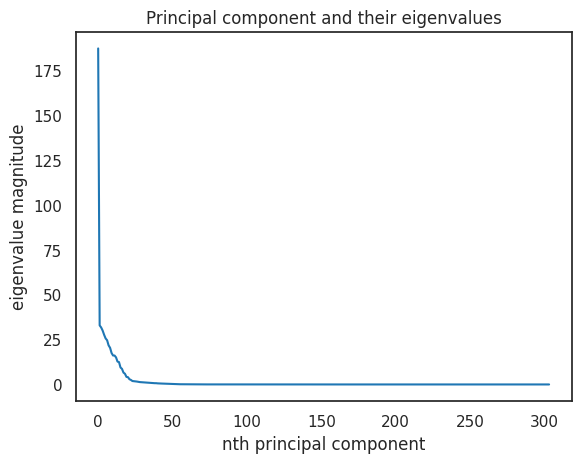

In [32]:
plt.plot(kernel_pca.eigenvalues_)
plt.title("Principal component and their eigenvalues")
plt.xlabel("nth principal component")
plt.ylabel("eigenvalue magnitude")
plt.show()

Again, by plotting the data points' projection onto the first two principal components, we can see that the data is linearly separable, demonstrating that kernel PCA performs better than our polynomial approximation:


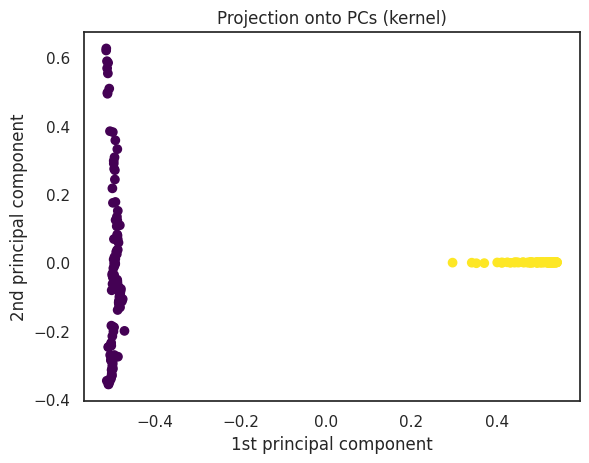

In [34]:
plt.scatter(score_kernel_pca[:, 0], score_kernel_pca[:, 1] ,c=y_test, cmap='viridis')
plt.title("Projection onto PCs (kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

In PCA, the reconstruction was exactly the same as the original component, if `n_components` is equal to the dimension of the original features. On the other hand, Kernel PCA does not actually span $\phi(\mathbf{x})$ but instead spans a subspace. Therefore, the inverse transformation will not always reconstruct the data, like in PCA. We can verify this by comparing the inverse transformation of Kernel PCA and PCA.


In [35]:
X_hat_kpca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

In [36]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_hat_pca = pca.inverse_transform(pca.transform(X_test))

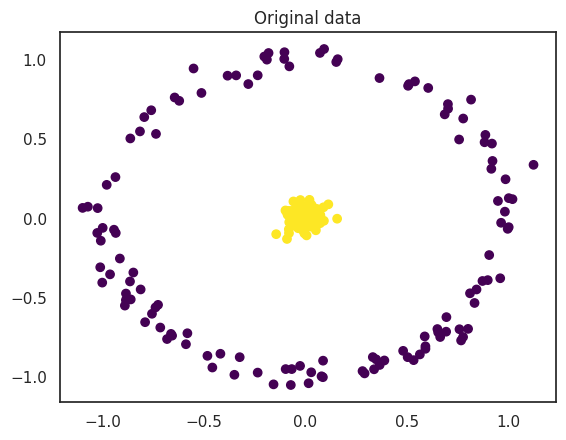

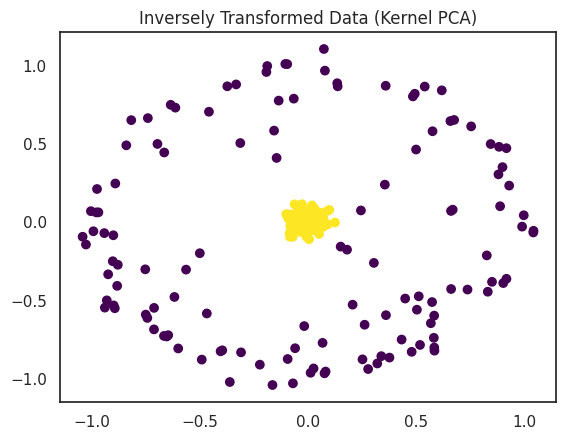

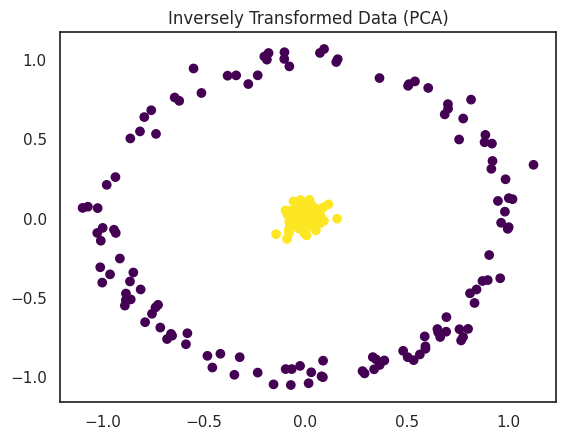

In [37]:
plt.scatter(X_test[:, 0], X_test[:, 1] ,c=y_test, cmap='viridis')
plt.title("Original data")
plt.show()

plt.scatter(X_hat_kpca[:, 0], X_hat_kpca[:, 1], c=y_test, cmap='viridis')
plt.title("Inversely Transformed Data (Kernel PCA)")
plt.show()

plt.scatter(X_hat_pca[:, 0], X_hat_pca[:, 1], c=y_test, cmap='viridis')
plt.title("Inversely Transformed Data (PCA)")
plt.show()

We can also calculate the error in the mean squared error for the inverse transformation, which is larger for Kernel PCA than for PCA, whose MSE is approximately 0, since the transformed data for it is identical to the original.


In [38]:
print("Mean squared error for Kernel PCA is:",((X_test - X_hat_kpca) ** 2).mean())

Mean squared error for Kernel PCA is: 0.011275231727547233


In [39]:
print("Mean squared error PCA is:" ,((X_test - X_hat_pca) ** 2).mean())

Mean squared error PCA is: 5.8139812353534686e-33


## Using Kernel PCA to Predict if You're the Richest Person in the World


Returning back to the question posed at the beginning of this lab, let's see if we can use Kernel PCA to help us better visualize if any trends exist among the richest people in the world. "The World's Billionaires" is an annual ranking documenting the net worth of the wealthiest billionaires in the world, compiled and published in March, annually, by the American business magazine - Forbes. For this lab, we obtained the dataset from <a href="https://www.kaggle.com/datasets/jjdaguirre/forbes-billionaires-2022?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01"> here</a>.


The features available from the dataset are:

*   Rank
*   Name
*   Net Worth - their net worth in billions USD
*   Age
*   Country
*   Source - their source of income
*   Industry - sector/industry/market segment in which each billionaire has made their fortune


### Data Analysis


We load the dataset and take a look to see if it loaded properly.


In [40]:
# Download the dataset and read it into a Pandas dataframe
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/billionaires.csv', index_col="Unnamed: 0")
df.head()

,rank,name,networth,age,country,source,industry
0,1,Elon Musk,$219 B,50,United States,"Tesla, SpaceX",Automotive
1,2,Jeff Bezos,$171 B,58,United States,Amazon,Technology
2,3,Bernard Arnault & family,$158 B,73,France,LVMH,Fashion & Retail
3,4,Bill Gates,$129 B,66,United States,Microsoft,Technology
4,5,Warren Buffett,$118 B,91,United States,Berkshire Hathaway,Finance & Investments


Checking the dataframe dimension, we notice that there are a total of 2600 samples.


In [41]:
df.shape

(2600, 7)

For each column, we can take a look at its unique values.


In [42]:
for col in df:
    print((f"{col} has {len(df[col].unique())} unique values."))

rank has 228 unique values.
name has 2598 unique values.
networth has 228 unique values.
age has 76 unique values.
country has 75 unique values.
source has 895 unique values.
industry has 18 unique values.


Notably, there are only 228 unique rank values, which is due to many ties in the rankings.


In [43]:
df[-100: -1]

,rank,name,networth,age,country,source,industry
2500,2448,Koo Bon-sik,$1.1 B,63,South Korea,LG,Technology
2501,2448,Suresh Krishna,$1.1 B,85,India,auto parts,Automotive
2502,2448,Nancy Lerner,$1.1 B,61,United States,"banking, credit cards",Finance & Investments
2503,2448,Norma Lerner,$1.1 B,86,United States,banking,Finance & Investments
2504,2448,Randolph Lerner,$1.1 B,60,United States,"banking, credit cards",Finance & Investments
...,...,...,...,...,...,...,...
2594,2578,Fu Gang,$1 B,51,China,pharma retailing,Healthcare
2595,2578,Jorge Gallardo Ballart,$1 B,80,Spain,pharmaceuticals,Healthcare
2596,2578,Nari Genomal,$1 B,82,Philippines,apparel,Fashion & Retail
2597,2578,Ramesh Genomal,$1 B,71,Philippines,apparel,Fashion & Retail


Also, we note that there are a lot of unique values for `source` and `names`, suggesting that they possibly won't help with rank prediction and can be excluded in our task. To examine the categorical variables `country` and`industry`, we plot their respective histograms:


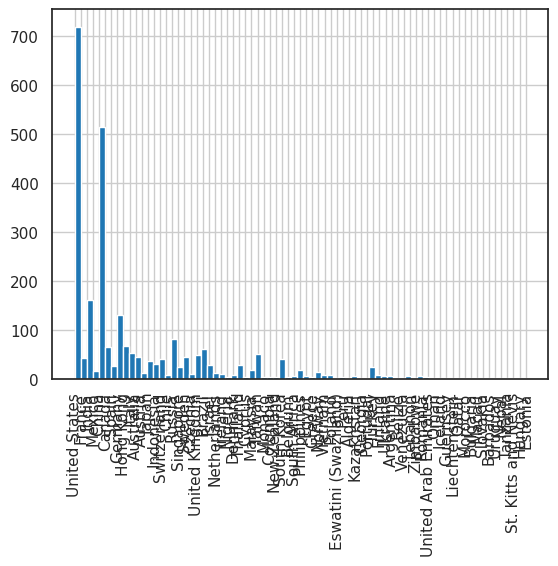

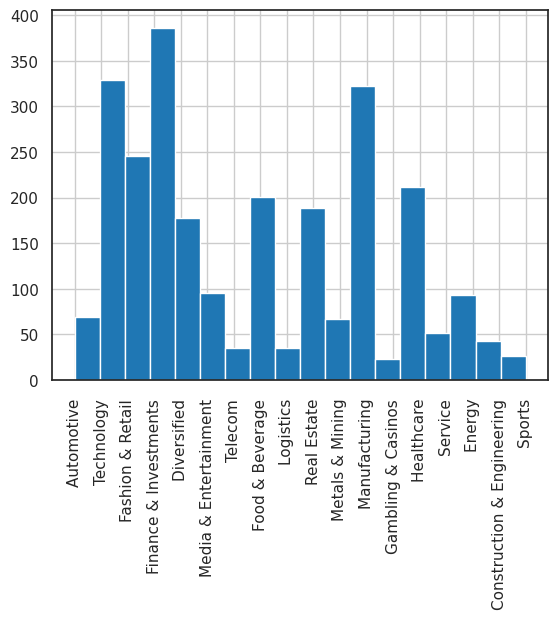

In [44]:
for column in ['country', 'industry']:
    df[column].hist(bins=len(df[column].unique()))
    plt.xticks(rotation='vertical')
    plt.show()

We can see that in this dataset, certain countries and industries contain more billionaires than others. We also examine the pairwise plot and correlation coefficient between age and rank, which tells us that the two features are negatively correlated.


,age,rank
age,1.000000,-0.124947
rank,-0.124947,1.000000


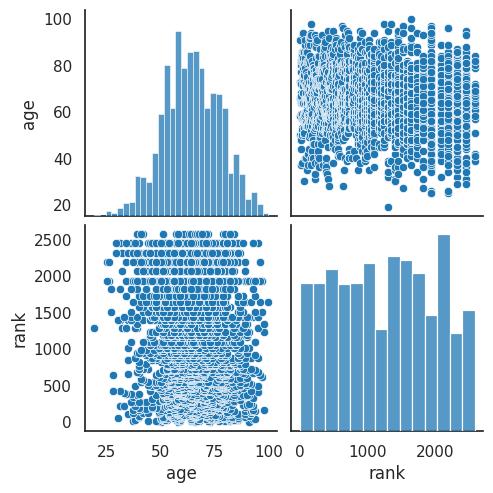

In [45]:
sns.pairplot(df[['age','rank']])
df[['age','rank']].corr()

For the variables that we don't use in prediction, we can save them separately:


In [46]:
B_names, networths, sources, industrys = df['name'], df['networth'], df['source'], df['industry']
B_names, networths, sources, industrys

(0                      Elon Musk 
 1                     Jeff Bezos 
 2       Bernard Arnault & family 
 3                     Bill Gates 
 4                 Warren Buffett 
                   ...            
 2595      Jorge Gallardo Ballart 
 2596                Nari Genomal 
 2597              Ramesh Genomal 
 2598              Sunder Genomal 
 2599       Horst-Otto Gerberding 
 Name: name, Length: 2600, dtype: object,
 0       $219 B
 1       $171 B
 2       $158 B
 3       $129 B
 4       $118 B
          ...  
 2595      $1 B
 2596      $1 B
 2597      $1 B
 2598      $1 B
 2599      $1 B
 Name: networth, Length: 2600, dtype: object,
 0                Tesla, SpaceX
 1                       Amazon
 2                         LVMH
 3                    Microsoft
 4           Berkshire Hathaway
                  ...          
 2595           pharmaceuticals
 2596                   apparel
 2597                   apparel
 2598                  garments
 2599    flavors and fragrances

We assign `rank`  to  `y`, our target, for prediction.


In [47]:
y = df['rank']
y.head()

0    1
1    2
2    3
3    4
4    5
Name: rank, dtype: int64

Next, let's drop all the features we are not going to use for the task:


In [48]:
df.drop(columns=['name', 'networth', 'source'], inplace=True)
df.head()

,rank,age,country,industry
0,1,50,United States,Automotive
1,2,58,United States,Technology
2,3,73,France,Fashion & Retail
3,4,66,United States,Technology
4,5,91,United States,Finance & Investments


Since our categorical variables `country` and `industry` are not ordinal, meaning that the categories don't have a specific order, we utilize one-hot encoding to convert their levels into dummy variables. Other remaining variables in the dataset don't require this, so we specify `remainder="passthrough"` to exclude them from the encoding. The features will then be assigned to the variable `data`.


In [49]:
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), ['country', 'industry'])], remainder="passthrough")
data = one_hot.fit_transform(df)

As of now, the output is a NumPy array, so let's get the feature names from the `one_hot` object using the method `get_feature_names_out()`, which will give  us the feature name with the name of the transformer as a prefix. For one-hot encoding, the prefix will also include the name of the column that generated the feature. Hence, we can strip out the prefix of the string for column names and save the labelled array as a dataframe:


In [50]:
names = one_hot.get_feature_names_out()
column_names = [name[name.find("_") + 1:] for name in  [name[name.find("__") + 2:] for name in names]]
new_data = pd.DataFrame(data.toarray(), columns=column_names)
new_data.head()

,Algeria,Argentina,Australia,Austria,Barbados,Belgium,Belize,Brazil,Bulgaria,Canada,...,Manufacturing,Media & Entertainment,Metals & Mining,Real Estate,Service,Sports,Technology,Telecom,rank,age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,58.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,73.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,66.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,91.0


### Applying Kernel PCA


Let's define a Kernel PCA object and fit it on this new data:


In [51]:
kernel_pca = KernelPCA(kernel='rbf', fit_inverse_transform=True, alpha=0.1)
kernel_score = kernel_pca.fit_transform(new_data)

### Using Kernel PCA to Improve Visualization


By plotting out the projection on the first two principal components and overlaying the plot with rank as the color, we are able to see a two dimensional visualization of the dataset, which can help distinguish any clusters that may be present in rankings. Here, the variable `ranking` was also defined, which will label the plot with the industry of the individual with that ranking value.


In [52]:
ranking = 13

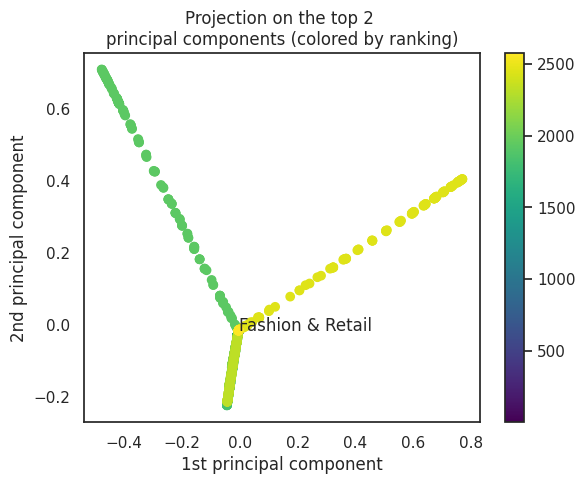

In [53]:
fig, ax = plt.subplots()
sc = ax.scatter(kernel_score[:, 0], kernel_score[:, 1], c=y, cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.annotate(industrys[ranking], (kernel_score[ranking, 0], kernel_score[ranking, 1]))
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection on the top 2 \nprincipal components (colored by ranking)")
plt.show()

We see a Bifurcation of the data dependent on the rank. The diverging branches suggest that difference in ranking can be associated with certain patterns in the data. This becomes more apparent in the 3-dimensional projection space:


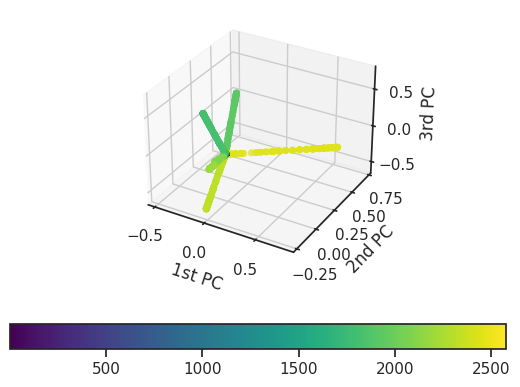

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(kernel_score[:, 0], kernel_score[:, 1], kernel_score[:, 2], c=y, cmap='viridis', linewidth=0.5)
fig.colorbar(sc, orientation='horizontal')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

Each line corresponds to a different range of ranking (represented by the varying colors), so let's see what happens when we apply PCA and plot the projection space in 1, 2, and 3 dimensions respectively.


In [55]:
pca = PCA()
score_pca = pca.fit_transform(new_data)

Even in the 1D projection space, we can see a pattern for rankings, which decreases as we move toward the right.


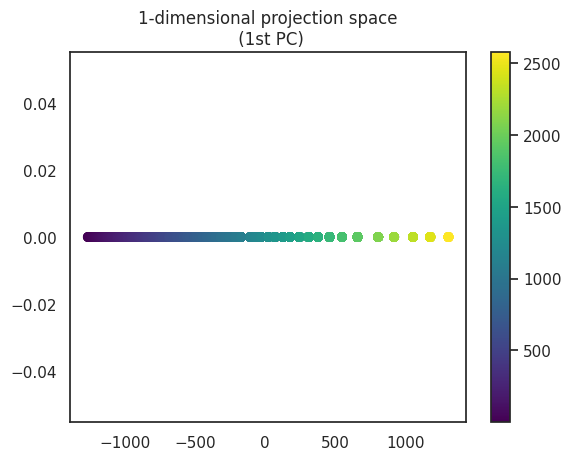

In [56]:
fig, ax = plt.subplots()
sc = ax.scatter(score_pca[:, 0], np.zeros(score_pca[:, 1].shape), c=y, cmap='viridis')
ax.set_title('1-dimensional projection space\n (1st PC)')
fig.colorbar(sc, orientation='vertical')
plt.show()

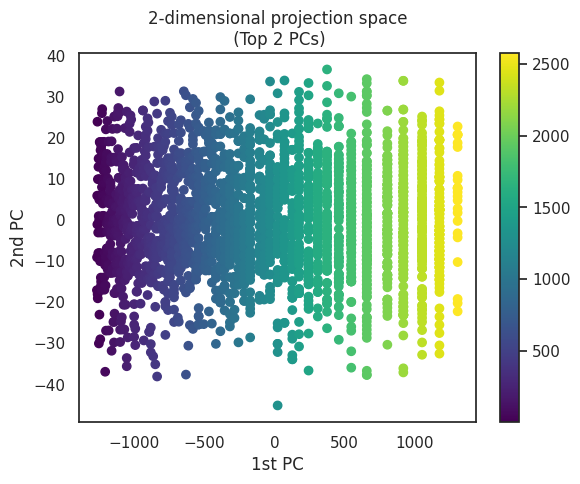

In [57]:
fig, ax = plt.subplots()
sc=ax.scatter(score_pca[:, 0], score_pca[:, 1], c=y, cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.set_title('2-dimensional projection space\n (Top 2 PCs)')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.show()

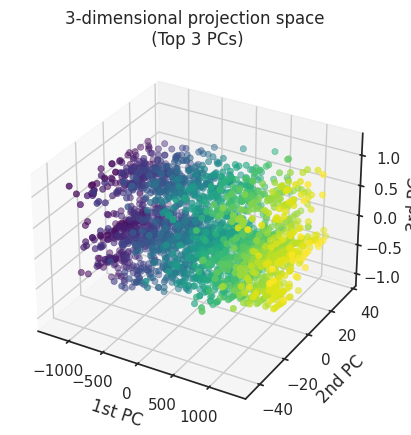

In [58]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc=ax.scatter(score_pca[:, 0], score_pca[:, 1], score_pca[:, 2], c=y, cmap='viridis', linewidth=0.5)
ax.set_title('3-dimensional projection space\n (Top 3 PCs)')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

In the 2-dimensional and 3-dimensional projection space, we see a similar trend that rankings change across the x-axis, meaning that most of its variation occurs in the projection on the first principal component.

From this example, we can observe that surely, some combination of the features `country`, `industry`, and `age` leads to consistent change in rankings. It is important to note that due to the nature of PCA in general, we aren't able to decrypt what that combination is.


### Using Kernel PCA to Improve Prediction


Even though we can't extract information that PCA deems to be a significant pattern, we can still feed the transformed features into a prediction model. When we compare Kernel PCA and PCA, we see that Kernel PCA generally performs better given a higher R^2 (coefficient of determination) score on the test set:


In [60]:
X_train, X_test, y_train, y_test = train_test_split(kernel_score, y, test_size=0.4, random_state=0)
lr = Ridge(alpha=0).fit(X_train, y_train)
print(f"Test set R^2 score for Kernel PCA: {lr.score(X_test, y_test)}")

Test set R^2 score for Kernel PCA: 0.9885118791787257


In [61]:
X_train, X_test, y_train, y_test = train_test_split(score_pca, y, test_size=0.40, random_state=0)
lr = Ridge(alpha=0).fit(X_train, y_train)
print(f"Test set R^2 score for PCA: {lr.score(X_test, y_test)}")

Test set R^2 score for PCA: 0.9999659543653209


# Exercises

You may now wonder, "What's the use in prediction, if we don't know which variables matter the most or what the significant split value is?" Depending on the task type, we don't always need to know that to produce interpretable results. Image datasets are one such case - in the following exercises, you will take advantage of dimension reduction to compare how well PCA and Kernel PCA remove noise in images while still retaining its key features.

Run the following code cell to complete the exercises.

First, we load the necessary train and test data, which are created using the USPS digits dataset that have been modified to include noise. In the image below, you can see that the digits are fairly hard to see clearly.


# Exercises

You may now wonder, "What's the use in prediction, if we don't know which variables matter the most or what the significant split value is?" Depending on the task type, we don't always need to know that to produce interpretable results. Image datasets are one such case - in the following exercises, you will take advantage of dimension reduction to compare how well PCA and Kernel PCA remove noise in images while still retaining its key features.

Run the following code cell to complete the exercises.

First, we load the necessary train and test data, which are created using the USPS digits dataset that have been modified to include noise. In the image below, you can see that the digits are fairly hard to see clearly.


In [62]:
X_train_noisy = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/X_train_noisy.csv').to_numpy()
X_test_noisy = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/X_test_noisy.csv').to_numpy()

In [63]:
# Helper function for plotting the digit images
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

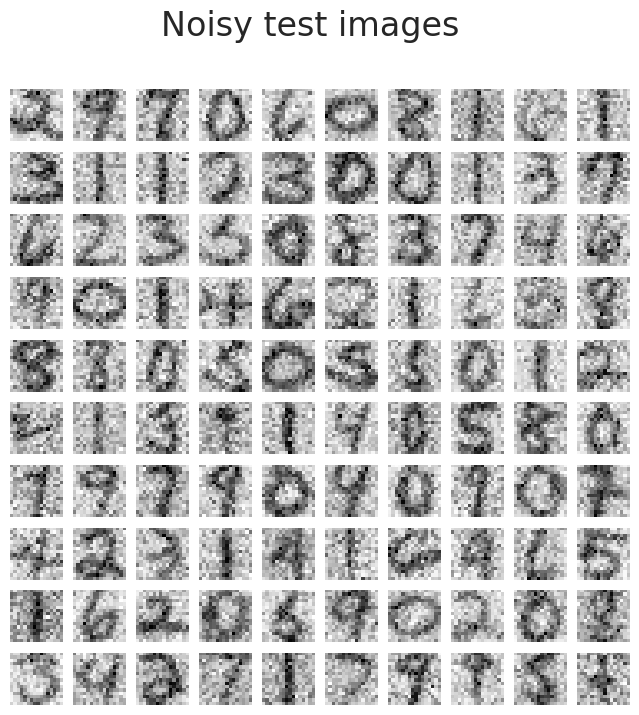

In [64]:
plot_digits(X_test_noisy, "Noisy test images")

## Exercise 1 - Fitting PCA & Kernel PCA Objects


First, create a `PCA` object called `pca` and fit it to the noisy test set `X_test_noisy`. Do the same for `KernelPCA` object `kernel_pca` using a RBF kernel.

Be mindful that `n_components` has to be a number between 0 and `min(n_samples, n_features) = 216` for PCA.


In [65]:
pca = PCA(n_components=35)
pca.fit(X_test_noisy)

PCA(n_components=35)

In [74]:
kernel_pca = KernelPCA(kernel='rbf', n_components=35, gamma=0.01, fit_inverse_transform=True, alpha=0.1)
kernel_pca.fit(X_test_noisy)

KernelPCA(alpha=0.1, fit_inverse_transform=True, gamma=0.01, kernel='rbf',
          n_components=35)

## Exercise 2 - Reconstruct the Digits


Next, we want to see if PCA or kernel PCA is better at removing noise in the original images. To do so, recall how we reconstructed the `make_circles` toy dataset earlier in this lab. (Hint: apply inverse transformation to the transformed data on a lower dimension.)


In [75]:
X_test_noisy

array([[ 0.44101908,  0.10047518,  0.25392112, ...,  0.34053568,
         0.61856106,  0.52163964],
       [-0.18139635, -0.34569995, -0.39304101, ...,  0.32535702,
         0.22381507,  0.34374102],
       [-0.33292395, -0.4853531 , -0.0693898 , ..., -0.27567963,
        -0.02542432,  0.00481985],
       ...,
       [ 0.07133676, -0.12987724,  0.3302351 , ...,  0.12501872,
        -0.00226681, -0.0307274 ],
       [-0.03887699,  0.28120068,  0.16289344, ..., -0.13761096,
        -0.05351462, -0.16251965],
       [ 0.2545434 , -0.27467683, -0.29239082, ..., -0.13500429,
         0.21307582,  0.00692786]])

In [76]:
pca_X_test_noisy = pca.transform(X_test_noisy)
pca_X_test_noisy

array([[ 6.98079146e-01,  9.18195038e-02, -5.39823493e-01, ...,
        -1.40913917e-01,  1.60514146e+00,  3.06689800e-01],
       [-8.18950235e-01,  2.69869692e+00, -5.30154140e-01, ...,
        -9.17429145e-02,  3.71705166e-01,  1.09305927e-01],
       [-2.03358537e+00,  2.15082438e+00, -9.97824415e-01, ...,
         2.60150542e-01, -1.39403053e+00, -3.43330141e-02],
       ...,
       [-2.15273455e+00,  7.81998618e-01,  1.67741982e-01, ...,
        -1.48175493e-04, -3.77077055e-01,  9.66491608e-01],
       [ 5.58239320e-01,  4.08751370e-01,  1.22580814e+00, ...,
         2.53270346e-01, -4.21417029e-01,  6.99241875e-01],
       [-3.17919305e+00, -7.71290728e-01, -3.39532095e-01, ...,
        -7.14323083e-01,  8.43354087e-01, -9.00155948e-01]])

In [77]:
X_hat_pca = pca.inverse_transform(pca_X_test_noisy)
X_hat_pca

array([[ 0.2946422 ,  0.28277231,  0.39233018, ...,  0.1916823 ,
         0.4461729 ,  0.52534021],
       [ 0.03106347, -0.09349374, -0.10390298, ...,  0.05989104,
         0.1163284 ,  0.23723293],
       [-0.42289883, -0.24280512, -0.13091901, ..., -0.09065903,
        -0.00550066, -0.06661551],
       ...,
       [ 0.10767913,  0.12496059,  0.20801469, ...,  0.09288298,
         0.15932419, -0.18215432],
       [ 0.07789769,  0.04375423,  0.06343804, ..., -0.00350985,
         0.06609519,  0.11489319],
       [ 0.3412269 , -0.02134854, -0.15525364, ..., -0.08117279,
         0.14387576,  0.02103315]])

In [78]:
kernel_X_test_noisy = kernel_pca.transform(X_test_noisy)
X_hat_kpca = kernel_pca.inverse_transform(kernel_X_test_noisy)

## Exercise 3 - Visualize Denoised Digit Images


Now, let's visualize the images reconstructed from PCA and kernel PCA! You may find the helper function `plot_digits` helpful. Which one reveals digit images with less noise?


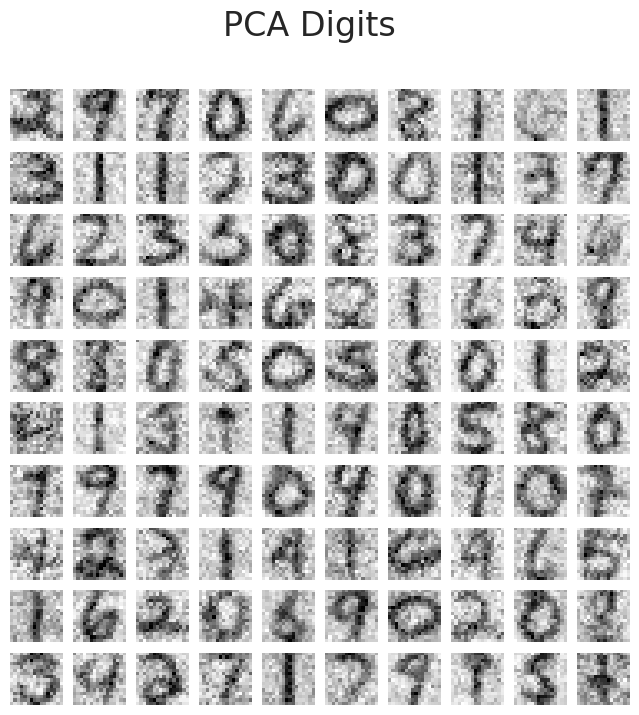

In [79]:
plot_digits(X_hat_pca, 'PCA Digits')

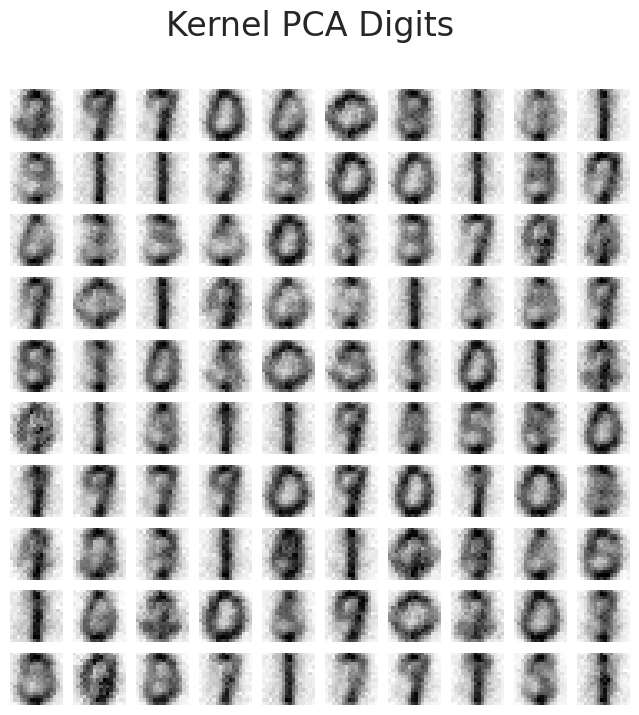

In [80]:
plot_digits(X_hat_kpca, 'Kernel PCA Digits')